In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter

In [2]:
#I. Датасет

In [3]:
#Получить массивы картинок в виде массива X, а также ответов labels

Размер массива X: (70000, 784)
Размер массива y: (70000,)


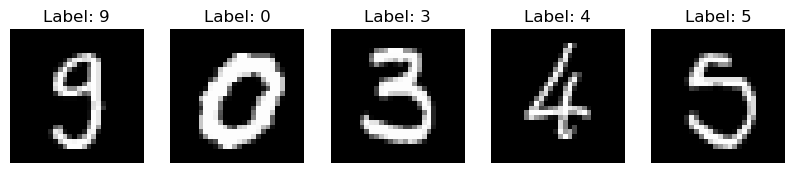

In [4]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist.data
y = mnist.target.astype(int)

X = X.astype(np.float32)

print(f'Размер массива X: {X.shape}')
print(f'Размер массива y: {y.shape}')

def plot_digits(X, y, n_samples=5):
    fig, axes = plt.subplots(1, n_samples, figsize=(10, 3))
    for i in range(n_samples):
        idx = np.random.randint(0, len(X))
        image = X[idx].reshape(28, 28)
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Label: {y[idx]}")
        axes[i].axis('off')
    plt.show()

plot_digits(X, y)

In [5]:
#II. Алгоритм PCA

In [6]:
#Реализуйте описанные выше шаги 1-3 внутри метода fit(), и шаг 4 внутри метода
#transform() класса my_PCA.

In [7]:
class my_PCA():
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.eigenvalues = None

    def fit(self, X):
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        cov_matrix = np.dot(X_centered.T, X_centered)

        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        sorted_index = np.argsort(eigenvalues)[::-1]
        self.eigenvalues = eigenvalues[sorted_index]
        sorted_eigenvectors = eigenvectors[:, sorted_index]

        if self.n_components is not None:
            self.components = sorted_eigenvectors[:, :self.n_components]
        else:
            self.components = sorted_eigenvectors

    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [8]:
#Заметьте, что собственные значения уже упорядочены в порядке убывания. Постройте
#график собственных значений, а также график отношения кумулятивной суммы к их
#полной сумме. Посмотрите, какую долю дисперсии данных покрывают первые 15 главных
#компонент? Как связаны между собой собственные числа и дисперсия данных?

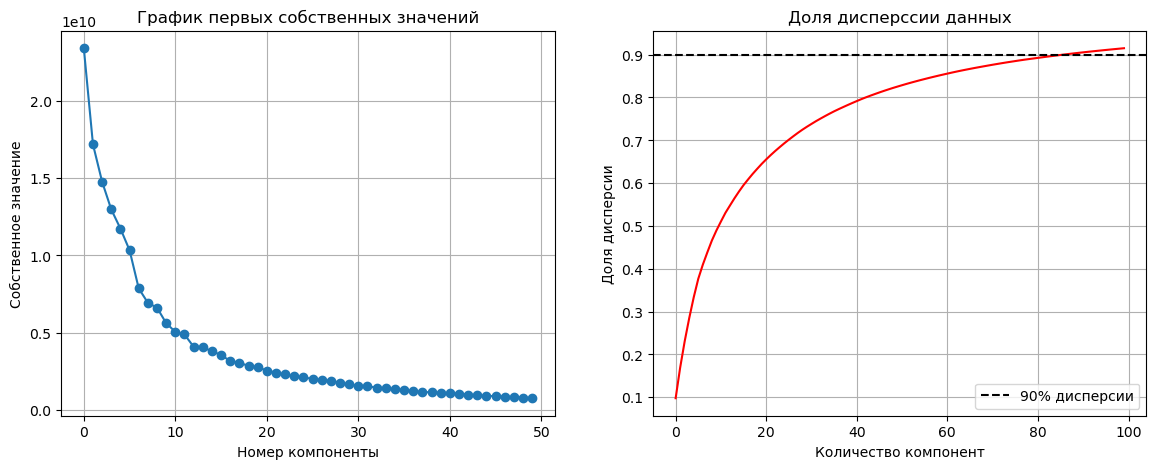

Первые 15 компонент покрываеют 58.05% дисперсии данных
Собственное значение прямо пропорционально дисперсии данных вдоль оси, задаваемой соответствующим собственным вектором. Чем больше число, тем больше информации несет эта компонента.


In [9]:
pca_full = my_PCA(n_components=None) 
pca_full.fit(X)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(pca_full.eigenvalues[:50], 'o-')
plt.title('График первых собственных значений')
plt.xlabel('Номер компоненты')
plt.ylabel('Собственное значение')
plt.grid()

total_variance = np.sum(pca_full.eigenvalues)
explained_variance_ratio = pca_full.eigenvalues / total_variance
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.subplot(1, 2, 2)
plt.plot(cumulative_variance[:100], 'r-')
plt.axhline(y=0.9, color='k', linestyle='--', label='90% дисперсии')
plt.title('Доля дисперссии данных')
plt.xlabel('Количество компонент')
plt.ylabel('Доля дисперсии')
plt.legend()
plt.grid()

plt.show()

variance_15 = cumulative_variance[14]
print(f'Первые 15 компонент покрываеют {variance_15:.2%} дисперсии данных')
print('Собственное значение прямо пропорционально дисперсии данных вдоль оси, '
      'задаваемой соответствующим собственным вектором. Чем больше число, тем больше информации несет эта компонента.')

In [10]:
#Изобразите на графике точки датасета в первых двух координатах главных компонент.
#Разным цифрам должны соответствовать разные цвета. 

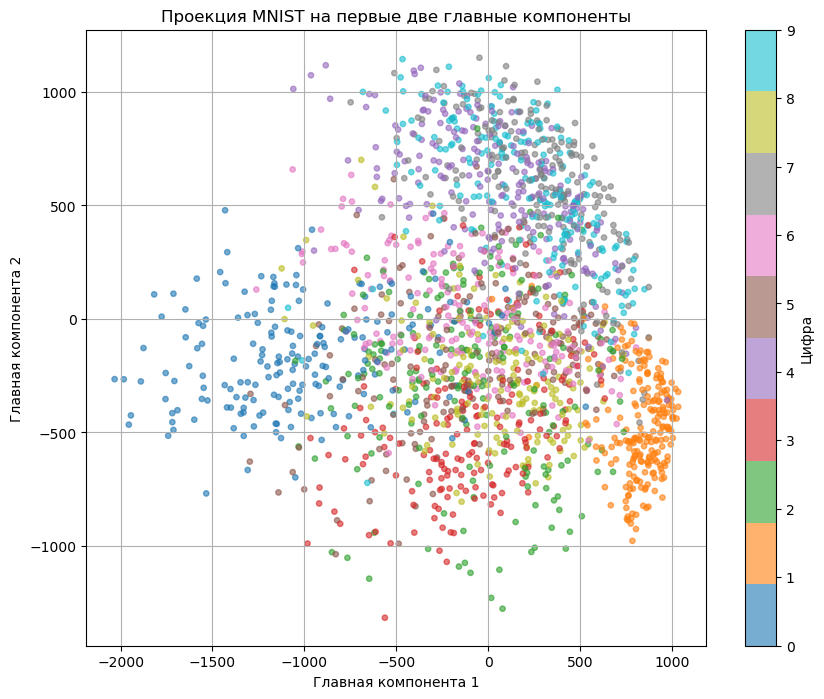

Классы формируют кластеры, но они сильно перекрываются
В пространстве всего двух компонент линейно разделить все цифры невозможно
Некоторые цифры (например, 0 или 1) отделяются лучше других


In [11]:
pca_2d = my_PCA(n_components=2)
X_projected = pca_2d.fit_transform(X)

subset_size = 2000
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_projected[:subset_size, 0], X_projected[:subset_size, 1], 
                      c=y[:subset_size], cmap='tab10', alpha=0.6, s=15)
plt.colorbar(scatter, label='Цифра')
plt.title('Проекция MNIST на первые две главные компоненты')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.grid(True)
plt.show()

print('Классы формируют кластеры, но они сильно перекрываются')
print('В пространстве всего двух компонент линейно разделить все цифры невозможно')
print('Некоторые цифры (например, 0 или 1) отделяются лучше других')

In [12]:
#III. Алгоритм kNN
#Реализуйте метод k-ближайших соседей в виде класса my_kNN

In [13]:
class my_kNN():
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for x_test in X:
            distances = np.sqrt(np.sum((self.X_train - x_test)**2, axis=1))
            
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            
            nearest_labels = self.y_train[nearest_indices]
            
            most_common = Counter(nearest_labels).most_common(1)[0][0]
            predictions.append(most_common)
            
        return np.array(predictions)

In [14]:
#Разбейте данные X и labels на обучающую и тестовую выборку, используя функцию
#train_test_split из модуля sklearn.model_selection.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_limit = 5000
test_limit = 500

X_train_sub = X_train[:train_limit]
y_train_sub = y_train[:train_limit]
X_test_sub = X_test[:test_limit]
y_test_sub = y_test[:test_limit]

print(f'Обучающая выборка: {X_train_sub.shape}')
print(f'Тестовая выборка: {X_test_sub.shape}')

Обучающая выборка: (5000, 784)
Тестовая выборка: (500, 784)


In [16]:
#Создайте классификатор my_kNN с числом соседей равным 5. Обучите классификатор
#на обучающих данных. Посчитайте точность на тестовой выборке, используя функцию
#accuracy_score из модуля sklearn.metrics. Какова точность полученного алгоритма?

In [17]:
knn_raw = my_kNN(n_neighbors=5)

knn_raw.fit(X_train_sub, y_train_sub)

y_pred_raw = knn_raw.predict(X_test_sub)

acc_raw = accuracy_score(y_test_sub, y_pred_raw)
print(f'Точность: {acc_raw:.2%}')

Точность: 92.60%


In [18]:
#Уменьшите размерность данных с помощью реализованного выше метода главных
#компонент. Примените алгоритм k-ближайших соседей к преобразованным данным. 
#Найдите параметры, при которых алгоритм даёт наибольшую точность на тестовой выборке. 

In [19]:
n_components_range = [1, 2, 5, 10, 15, 20, 30, 40, 50, 64]

n_neighbors_range = [1, 3, 5, 7, 10, 15, 20, 25, 30]

results = {}

pca_max = my_PCA(n_components=64)
pca_max.fit(X_train_sub)
X_train_pca_full = pca_max.transform(X_train_sub)
X_test_pca_full = pca_max.transform(X_test_sub)

best_acc = 0
best_params = (0, 0)

print('Перебор начат')

for n_comp in n_components_range:
    X_train_current = X_train_pca_full[:, :n_comp]
    X_test_current = X_test_pca_full[:, :n_comp]
    
    for k in n_neighbors_range:
        knn = my_kNN(n_neighbors=k)
        knn.fit(X_train_current, y_train_sub)

        y_pred = knn.predict(X_test_current)
        acc = accuracy_score(y_test_sub, y_pred)
        
        results[(n_comp, k)] = acc
        
        if acc > best_acc:
            best_acc = acc
            best_params = (n_comp, k)

print(f'Лучшая точность: {best_acc:.2%}')
print(f'Лучшие параметры: {best_params[0]} компонент, {best_params[1]} соседей')

Перебор начат
Лучшая точность: 95.80%
Лучшие параметры: 50 компонент, 1 соседей


In [20]:
#Постройте графики зависимости доли
#правильных ответов в зависимости от числа компонент и соседей.

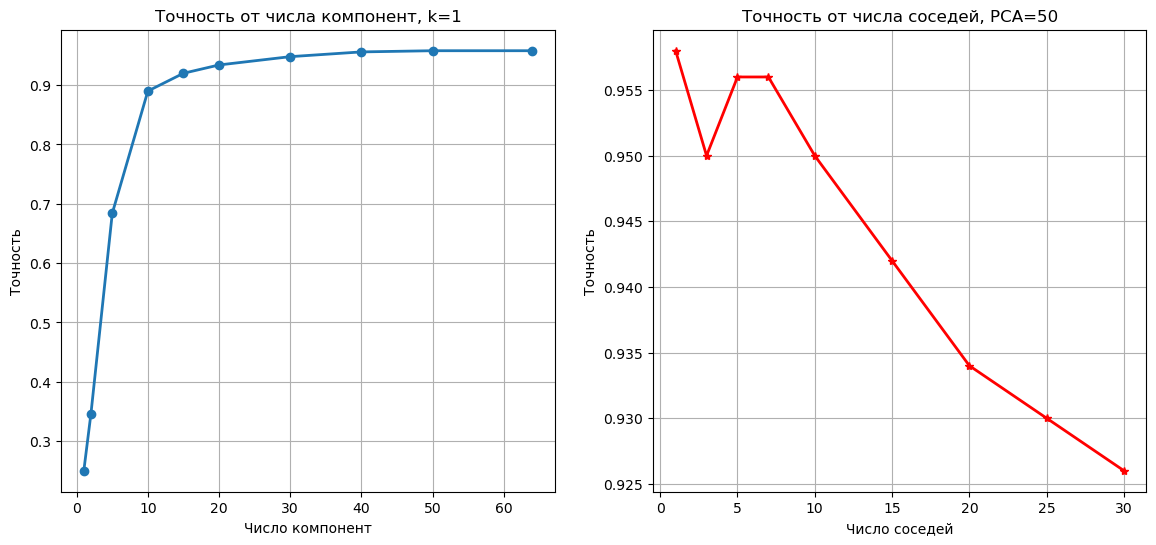

In [21]:
plt.figure(figsize=(14, 6))

best_k = best_params[1]
acc_by_comp = [results[(comp, best_k)] for comp in n_components_range]

plt.subplot(1, 2, 1)
plt.plot(n_components_range, acc_by_comp, 'o-', linewidth=2)
plt.title(f'Точность от числа компонент, k={best_k}')
plt.xlabel('Число компонент')
plt.ylabel('Точность')
plt.grid(True)

best_comp = best_params[0]
acc_by_k = [results[(best_comp, k)] for k in n_neighbors_range]

plt.subplot(1, 2, 2)
plt.plot(n_neighbors_range, acc_by_k, 'r*-', linewidth=2)
plt.title(f'Точность от числа соседей, PCA={best_comp}')
plt.xlabel('Число соседей')
plt.ylabel('Точность')
plt.grid(True)

plt.show()